# sample of stuff within 1 kpc

Benjamin Pennell

--

Max Planck Institut für Astronomie, Heidelberg

---

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from astropy.io import ascii
from scipy.optimize import minimize
from scipy.stats import kstest, ks_2samp
import pickle
from scipy.interpolate import RegularGridInterpolator
import h5py
import matplotlib
import pandas as pd

from astropy.table import Table
from astroquery.gaia import Gaia

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Create the catalogue

### load the msms catalogue, relevant columns

In [2]:
msms = h5py.File("../BigData/msms_36m_v0.hdf5", "r")

In [3]:
new_table = Table()

In [4]:
labels = ["source_id", "parallax", "ra", "dec", "phot_g_mean_mag", "mass_single", "predicted_class", "bp_rp", "mh_single"]
for label in labels:
    new_table.add_column(np.array(msms["table"]["columns"][label]["data"]), name=label)

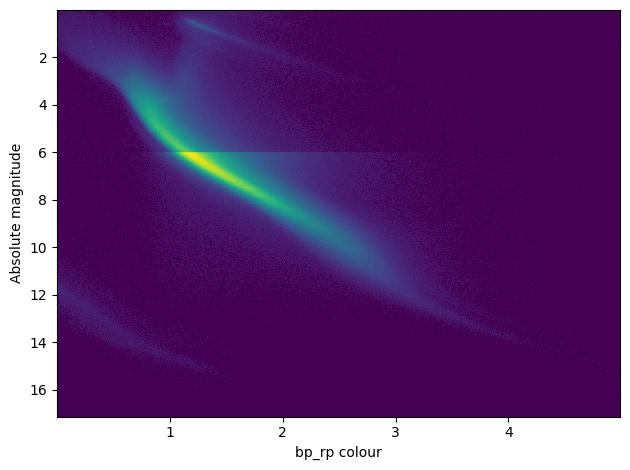

In [7]:
bp_rp = new_table["bp_rp"]
parallax = new_table["parallax"]
gmag = new_table["phot_g_mean_mag"]
absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10

plt.hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4));
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);
plt.tight_layout()

In [5]:
SINGLE_MASK = new_table["predicted_class"] == 0
PARALLAX_MASK = (new_table["parallax"] < 10) & (new_table["parallax"] > 5) # 50-250pc
MASS_MASK = (new_table["mass_single"] < 0.4) & (new_table["mass_single"] > 0.1)
ARBITRARY_CUT = new_table["bp_rp"] > 2
total_mask = SINGLE_MASK & PARALLAX_MASK & MASS_MASK & ARBITRARY_CUT
part_mask = SINGLE_MASK & MASS_MASK & ARBITRARY_CUT & (new_table["parallax"] < 20)

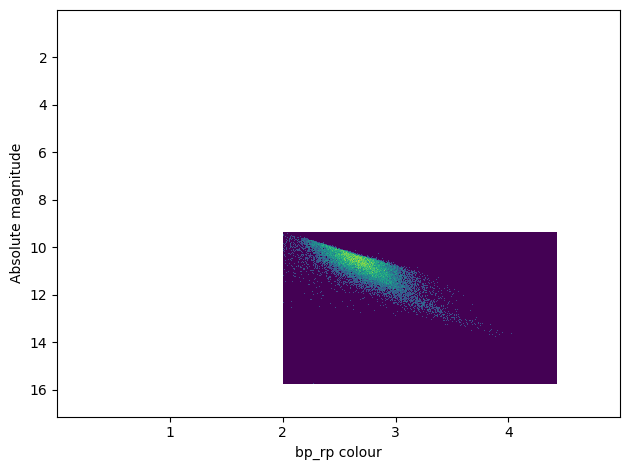

In [8]:
bp_rp_red = bp_rp[total_mask]
mags_red = absolute_magnitudes[total_mask]

plt.hist2d(bp_rp_red, mags_red, bins=1000, norm=matplotlib.colors.PowerNorm(0.4));
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);
plt.tight_layout()

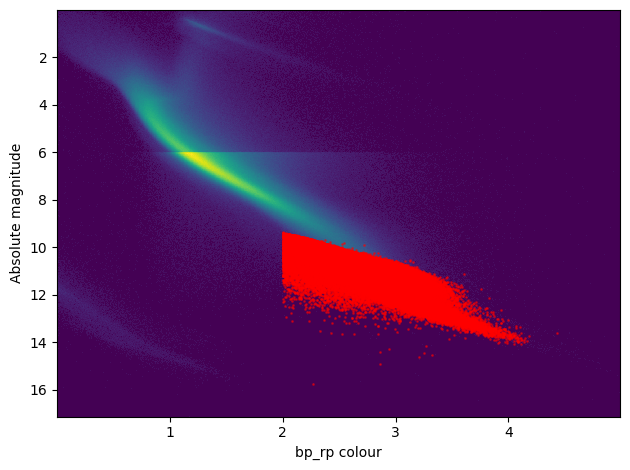

In [9]:
plt.hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4));
plt.scatter(bp_rp_red, mags_red, c="r", s=1, alpha=0.5)
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);
plt.tight_layout()

In [6]:
masked_table = new_table[total_mask]

In [7]:
len(new_table), len(masked_table), "{:.2f}%".format(len(masked_table)/len(new_table)*100)

(35831031, 275438, '0.77%')

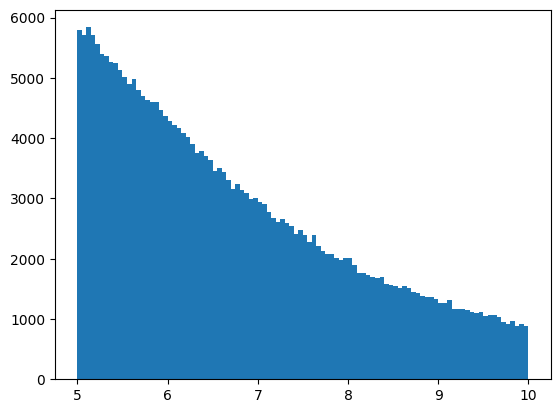

In [8]:
plt.hist(masked_table["parallax"], bins=100);

### append things from gaia

In [11]:
job = Gaia.launch_job_async("""SELECT *
                                FROM gaiadr3.nss_two_body_orbit AS g
                                WHERE g.parallax > 5
                                AND g.parallax < 10
                                """)

nss_table = job.get_results()

job = Gaia.launch_job_async("""SELECT *
                                FROM gaiadr3.nss_acceleration_astro AS g
                                WHERE g.parallax > 5
                                AND g.parallax < 10
                                """)

accel_table = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [9]:
# a test
job = Gaia.launch_job_async(r"""select pmra, pmdec, ruwe
                        from gaiadr3.gaia_source 
                        where source_id = 5478926884285078784""")
results = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [21]:
import os
os.environ["XDG_CACHE_HOME"] = os.path.expanduser("~/.astroquery_tmp")

In [12]:
def chunk_list(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

batch_size = 1000  # Gaia can usually handle 50-100 IDs per query

all_results = []

for batch in tqdm(list(chunk_list(masked_table["source_id"], batch_size))):
    ids_str = ",".join(str(sid) for sid in batch)
    query = f"""
    SELECT source_id, pmra, pmdec, ruwe
    FROM gaiadr3.gaia_source
    WHERE source_id IN ({ids_str})
    """
    job = Gaia.launch_job_async(query, verbose=False)
    results = job.get_results()
    all_results.append(results.to_pandas())

df = pd.concat(all_results, ignore_index=True)

  0%|          | 0/276 [00:00<?, ?it/s]

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [13]:
masked_table.add_column(np.zeros(len(masked_table)), name="pmra")
masked_table.add_column(np.zeros(len(masked_table)), name="pmdec")
masked_table.add_column(np.zeros(len(masked_table)), name="ruwe")
masked_table.add_column(np.zeros(len(masked_table)), name="solution_type")

In [14]:
mask = np.in1d(masked_table["source_id"], df["source_id"])  # boolean mask for rows to update
data_indices = np.where(mask)[0]

# Step 2: Map update indices
update_map = {sid: i for i, sid in enumerate(df['source_id'])}

# Step 3: Update only the desired columns
for col in ['pmra', 'pmdec', 'ruwe']:
    # Pick corresponding values from updates_df
    masked_table[col][data_indices] = [df[col][update_map[sid]] for sid in masked_table['source_id'][data_indices]]

/tmp/ipykernel_3723841/2458955827.py:1: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  mask = np.in1d(masked_table["source_id"], df["source_id"])  # boolean mask for rows to update


In [17]:
accel_ids = list(accel_table["source_id"])
nss_ids = list(nss_table["source_id"])

for row in tqdm(masked_table):
    if row["ruwe"] < 1.4:
        row["solution_type"] = int(0)
    elif row["source_id"] in nss_ids:
        row["solution_type"] = int(12)
    elif row["source_id"] in accel_ids:
        if accel_table[accel_table["source_id"] == row["source_id"]]["nss_solution_type"][0] == "Acceleration7":
            row["solution_type"] = int(7)
        elif accel_table[accel_table["source_id"] == row["source_id"]]["nss_solution_type"][0] == "Acceleration9":
            row["solution_type"] = int(9)
    else:
        row["solution_type"] = int(5)

  0%|          | 0/275438 [00:00<?, ?it/s]

In [ ]:
masked_table.remove_column("col0")

In [18]:
lowrs = len(masked_table[masked_table["solution_type"] == 0])/len(masked_table)*100
highrs = len(masked_table[masked_table["solution_type"] == 5])/len(masked_table)*100
accels = len(masked_table[masked_table["solution_type"] == 7])/len(masked_table)*100
jerks = len(masked_table[masked_table["solution_type"] == 9])/len(masked_table)*100
nsss = len(masked_table[masked_table["solution_type"] == 12])/len(masked_table)*100
highruwes = len(masked_table[masked_table["ruwe"] > 1.4])/len(masked_table)*100
print(lowrs, highrs, accels, jerks, nsss)
print(int(accels/100*len(masked_table)), int(jerks/100*len(masked_table)), int(nsss/100*len(masked_table)))

95.00504650774403 4.769494405274508 0.12779645510060342 0.03267522999731337 0.06498740188354549
352 90 179


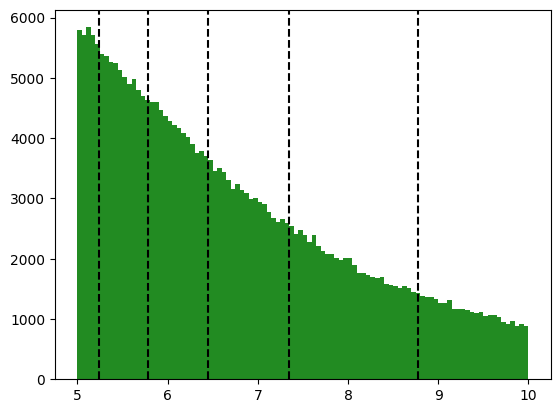

In [19]:
plt.hist(masked_table["parallax"], bins=100, color="forestgreen");
plt.axvline(np.percentile(masked_table["parallax"], 10), c="k", linestyle="--");
plt.axvline(np.percentile(masked_table["parallax"], 30), c="k", linestyle="--");
plt.axvline(np.percentile(masked_table["parallax"], 50), c="k", linestyle="--");
plt.axvline(np.percentile(masked_table["parallax"], 70), c="k", linestyle="--");
plt.axvline(np.percentile(masked_table["parallax"], 90), c="k", linestyle="--");

In [20]:
masked_table.write('./data/200pc_mdwarfs.fits', format='fits', overwrite=True)

## Plots

In [2]:
t_loaded = Table.read('../data/200pc_mdwarfs.fits', format='fits')

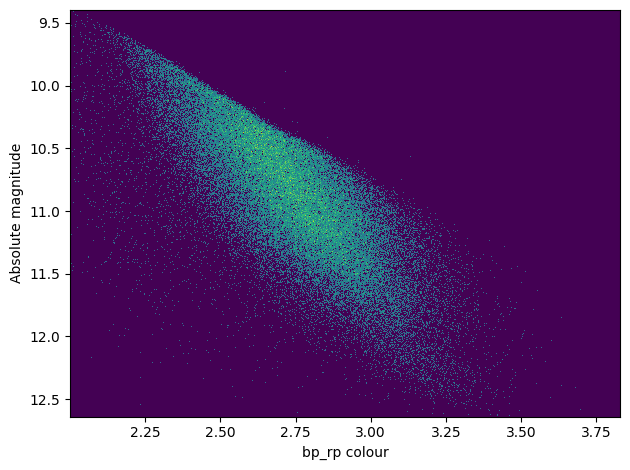

In [3]:
bp_rp = t_loaded["bp_rp"]
parallax = t_loaded["parallax"]
gmag = t_loaded["phot_g_mean_mag"]
absolute_magnitudes = gmag + 5 * np.log10(parallax) - 10

plt.hist2d(bp_rp, absolute_magnitudes, bins=1000, norm=matplotlib.colors.PowerNorm(0.4));
plt.ylabel("Absolute magnitude");
plt.xlabel("bp_rp colour");
plt.ylim(bottom=np.max(absolute_magnitudes), top=np.min(absolute_magnitudes));
plt.xlim([np.min(bp_rp), np.max(bp_rp)]);
plt.tight_layout()

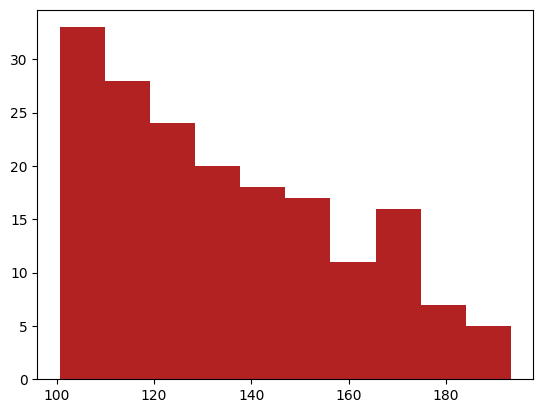

In [22]:
plt.hist(1000/t_loaded[t_loaded["solution_type"] == 12]["parallax"], color="firebrick");